<a href="https://colab.research.google.com/github/asabrems/MNIST_digitRecognizer/blob/modification1/digital_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
import os
import numpy as np
import pandas as pd


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

cuda = torch.cuda.is_available()
cuda

True

In [3]:
'''
!pip install --upgrade kaggle

!mkdir ~/.kaggle/
import os, zipfile, tarfile
os.environ['KAGGLE_USERNAME'] = "adwoabremang" 
os.environ['KAGGLE_KEY'] = "caf363d90120a5f1504bd757f236856f"

!kaggle competitions download -c digit-recognizer

!unzip -q test.csv.zip
!unzip -q train.csv.zip
'''

'\n!pip install --upgrade kaggle\n\n!mkdir ~/.kaggle/\nimport os, zipfile, tarfile\nos.environ[\'KAGGLE_USERNAME\'] = "adwoabremang" \nos.environ[\'KAGGLE_KEY\'] = "caf363d90120a5f1504bd757f236856f"\n\n!kaggle competitions download -c digit-recognizer\n\n!unzip -q test.csv.zip\n!unzip -q train.csv.zip\n'

In [4]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submiss = pd.read_csv('sample_submission.csv')
submiss

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [5]:
test.shape

(28000, 784)

In [6]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#dataloader

i will come back to the rest but now i want to try and understand the data.

In [7]:
train_x = train.drop(labels =['label'],axis =1)
train_labels = train['label']
train_labels

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [8]:
train_pixels = train_x/250.0
test_pixels = test/250.0

train_ = train_pixels.values.reshape(-1,28,28,1)  # the image is 28px by 28px , the image has 1 in channel
test_= test_pixels.values.reshape(-1,28,28,1)
train_.shape

(42000, 28, 28, 1)

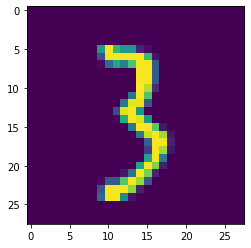

In [9]:
plt.imshow(train_[234][:,:,0])

In [10]:
test_.shape

(28000, 28, 28, 1)

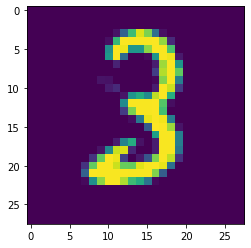

In [11]:
plt.imshow(test_[4][:,:,0])

converting the numpyarray to a PIL image 

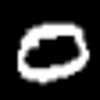

In [12]:
image_array = test_[1][:,:,0]
type(image_array)
orig_img = Image.fromarray(image_array*255).convert('RGB')
orig_img.resize((100,100))

I need to create a dataloader

In [13]:
#abit of information on weights initialization
#https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/

def init_weights(value):
  if type(value) == nn.Conv2d or type(value) == nn.Linear:
    torch.nn.init.kaiming_uniform_(value.weight, mode='fan_in', nonlinearity='relu') # since we are using relu's we go for this ... also know as "He"
    #torch.nn.init.xavier_uniform_(value.weight.data, gain=1.0)

In [14]:
# source of code ------- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

Image rotation 

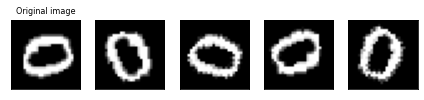

In [15]:
original_img = orig_img
rotater = transforms.RandomRotation(degrees=(0, 360))
rotated_imgs = [rotater(original_img) for _ in range(4)]
plot(rotated_imgs)

random perspectives 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


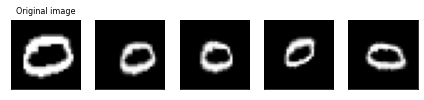

In [16]:
perspective_transformer = transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

In [17]:
train_data, val_data = train_test_split(train, test_size=0.33, shuffle=True)

In [18]:
class Dataset_(Dataset):
  def __init__(self,data,transforms,Train = True): 
    self.X = data 
    self.y = None
    
    if Train: 
      self.X = self.X.drop(labels =['label'],axis =1) 
      self.y =torch.from_numpy(data['label'].values)
    self.X = self.X/255.0 
    self.X = self.X.values.reshape(-1,1,28,28) 
    self.transform = transforms


  def __len__(self):
    length = len(self.X)
    return length
  
  def __getitem__(self,idx):
    features =  self.X[idx]

    labels = None
    if self.y is not None: 
      
      labels = self.y[idx]
      return self.transform(features), labels #figure out a way to add the transforms 
    else:
      return self.transform(features)

In [19]:
# this is a simple image identification hence adding alot of transforms complicates it 
transform = transforms.Compose(
    [transforms.ToTensor()
     #transforms.RandomRotation(degrees=(0, 360))
     #transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
    ])



In [20]:
train_dataset = Dataset_(train_data,transform)
train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=1)


In [21]:
val_dataset = Dataset_(val_data,transform)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=True, num_workers=1)

In [22]:
test_dataset = Dataset_(test,transform,False)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=1)


#CNN processing the data 
no data cleaning and stuff

In [23]:
class Model(nn.Module):#next hurdle is the model 
  def __init__(self,num_feat,hidden_size,num_classes, stride = 1):
    super(Model, self).__init__()
    kernel_size = 4
    self.conv1 = nn.Conv2d(num_feat, hidden_size[0], kernel_size =4 , stride = stride, bias = False)
    self.bn = nn.BatchNorm2d(hidden_size[0])
    self.dropout = nn.Dropout(0.3)
    self.conv2 = nn.Conv2d(hidden_size[0],hidden_size[1], kernel_size = 4, stride = stride, bias = False)
    self.pool = nn.MaxPool2d(2,2)
    #this side is for flattenig, then fully connection and softmax
    self.fc1 = nn.Linear(hidden_size[1]*4*4, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)



  def forward(self,x):
    x= x.reshape(-1,1,28,28)
    '''print('data>>>>>',x.shape,x.type()) 
    
    #print('data>>>>>',x.shape,x.type()) # need to reshape (batch,in_channel,height,width)https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html#torch.nn.functional.conv2d
    
    x= self.conv1(x)
    print('conv1',x.shape)
    x= F.relu(x)
    print('relu1',x.shape)
    x= self.pool(x)
    print('pool1',x.shape)
    x= self.conv2(x)
    print('conv2',x.shape)
    x= F.relu(x)
    print('relu2',x.shape)
    x= self.pool(x)
    print('pool2',x.shape)'''
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # now we need to flatten 
    x = torch.flatten(x, 1)  #saying something about leaving out batches 
    #fully connection
    #print('flatten',x.shape)
    x = F.relu(self.fc1(x))
    #print('linear1',x.shape)
    x = F.relu(self.fc2(x))
    #print('linear2',x.shape)
    x = self.fc3(x)
    #print('linear3',x.shape)
    return x


In [24]:
def train_model(model, data_loader):
        model.train()
        avg_loss = 0.0
        for batch_num, (feats,labels) in enumerate(data_loader):
            feats, labels = feats.to(device), labels.to(device)
            #feats = torch.Tensor(feats, dtype=torch.long, device=device)
            #labels =  torch.Tensor(labels, dtype=torch.long, device=device)
            
            optimizer.zero_grad()
            outputs = model(feats.float()) #https://discuss.pytorch.org/t/runtimeerror-expected-scalar-type-long-but-found-float/103299
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
    
            avg_loss += loss.item()
       
            #val_loss, val_acc = test_classify(model, data_loader)
        avg_loss /= len(data_loader)
        #train_loss, train_acc = test_classify(model, data_loader)
        torch.cuda.empty_cache()
        print('Train Loss:{:.4f}'.format(avg_loss))
        #print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\t'.
                  #format(train_loss, train_acc))
            
def test_classify(model, test_loader):
          model.eval()
          test_loss = []
          accuracy = 0
          total = 0

          for batch_num, (feats, labels) in enumerate(test_loader):
              feats, labels = feats.to(device), labels.to(device)
              outputs = model(feats.float())
              _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
              pred_labels = pred_labels.view(-1)
              
              loss = criterion(outputs, labels.long())
              
              accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
              total += len(labels)
              test_loss.extend([loss.item()]*feats.size()[0])
              torch.cuda.empty_cache()
              del feats
              del labels
              del outputs
              del pred_labels
              del loss

          model.train()
          val_loss = np.mean(test_loss)
          val_acc = accuracy/total
          print('validation Loss: {:.4f}\t validation Accuracy: {:.4f}\t'.
                  format(val_loss, val_acc))
          #return np.mean(test_loss), accuracy/total





In [25]:
numEpochs = 10
num_feats = 1 
learningRate = 0.08#0.15
weightDecay =  5e-5
hidden_size= [32,64]

num_classes = len(train)
print(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network = Model(num_feats,hidden_size, num_classes)
network.apply(init_weights)
network.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma =0.1)
network.train()
for epoch in range(numEpochs):
    train_model(network, train_dataloader)
    test_classify(network, val_dataloader)
    torch.save(network.state_dict(), str(epoch+1)+'.pth')
    print(str(epoch+1)+" done")

42000


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss:0.7718
validation Loss: 0.1148	 validation Accuracy: 0.9658	
1 done
Train Loss:0.0878
validation Loss: 0.0721	 validation Accuracy: 0.9771	
2 done
Train Loss:0.0506
validation Loss: 0.0619	 validation Accuracy: 0.9807	
3 done
Train Loss:0.0373
validation Loss: 0.0597	 validation Accuracy: 0.9825	
4 done
Train Loss:0.0324
validation Loss: 0.0648	 validation Accuracy: 0.9814	
5 done
Train Loss:0.0257
validation Loss: 0.0797	 validation Accuracy: 0.9783	
6 done
Train Loss:0.0216
validation Loss: 0.0519	 validation Accuracy: 0.9850	
7 done
Train Loss:0.0094
validation Loss: 0.0623	 validation Accuracy: 0.9844	
8 done
Train Loss:0.0082
validation Loss: 0.0588	 validation Accuracy: 0.9854	
9 done
Train Loss:0.0048
validation Loss: 0.0647	 validation Accuracy: 0.9850	
10 done


In [26]:
def test_model(model, data_loader): #change certain variables
        model.eval()
        test_pred = torch.LongTensor()
        for batch_num, feats in enumerate(data_loader):
            feats= feats.to(device)        
    
            outputs = model(feats.float()) #https://discuss.pytorch.org/t/runtimeerror-expected-scalar-type-long-but-found-float/103299
            pred = outputs.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
        return test_pred

In [27]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [28]:
test_pred = test_model(network, test_dataloader)


In [29]:
test_pred.numpy().shape

(28000, 1)

In [30]:
np.c_[test_pred.numpy()].shape

(28000, 1)

In [31]:
np.c_[np.arange(1, len(test_dataset)+1), test_pred.numpy()]

array([[    1,     2],
       [    2,     0],
       [    3,     9],
       ...,
       [27998,     3],
       [27999,     9],
       [28000,     2]])

In [32]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [33]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [34]:
out_df.to_csv('submission.csv', index=False)# [accuracy 0.97853] new score [0.98546]